# XRD Troubleshooting
Noticing some issues in the XRD data used in this study. Trying to sort through tha by doing a deep dive into each chemistry

### For each chemistry
0. Look at the effect of background subtraction using [100] peak
1. [100] center, full, edge: how many peaks and locations (e.g. determination of lattice)
2. [200] center, full, edge: how many peaks and locations (e.g. determination of lattice)
3. [111] or some off normal peak: how many peaks and locations (e.g. determination of lattice)
4. Consideration of competing products (PbI2, PbBr2, PbCl2)
5. Look at other sources of data (Amy's replicates)  

In [20]:
#   Import Necessary Packages and Define Functions

import glob
import pandas as pd
import plotly.express as px
import numpy as np
import math
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from scipy.sparse import linalg
from numpy.linalg import norm
import matplotlib.pyplot as plt

savgol_average = 17

def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

def trim_data(x,data,limit1,limit2):
    set1 = find_nearest(x,limit1)
    set2 = find_nearest(x,limit2)
    return x[set1:set2], data[set1:set2]

def twotheta_to_q(angle, lam = 1.54060):
  angle_rad = angle/2*np.pi/180
  return 4*np.pi*np.sin(angle_rad)/lam

            
def normal_gaussian(x, a, b, c): 
    #nomralized gaussian curve for XRD analysis:
    #x is a 1D array of two theta or q values
    #a is the instensity 
    #b is the peak position and 
    #c is the variance (FWHM = sqrt(2ln2)*c)
    return a/(c*np.sqrt(2*math.pi))*np.exp(-(x - b)**2/(2*c**2))

def lorentz(x, a, b, c):
    #generic lorentzian curve, for xrd analysis
    #x is a 1D array of two theta or q values
    #a is the max intensity of the peak and representative of crystalling
    #b is the peak position and 
    # c is the FWHM
    return a/np.pi*((c/2)/((x-b)**2+(c/2)**2))

def pvoigt(x, e, a, b, c):
    #pseudovoigt curve common in xrd analysis
    #linear combination of lorentzian and gaussian curves
    #e is the fraction that is lorentzian
    c_g = c/(2*np.sqrt(2*np.log(2)))
    return e*lorentz(x, a, b, c) + (1-e)*normal_gaussian(x,a,b,c_g)

def double_pvoigt(x, e, a1, b1, c1, a2, b2, c2):
    #pseudovoigt curve common in xrd analysis
    #linear combination of lorentzian and gaussian curves
    #e is the fraction that is lorentzian
    c_g1 = c1/(2*np.sqrt(2*np.log(2)))
    c_g2 = c2/(2*np.sqrt(2*np.log(2)))
    return e*lorentz(x, a1, b1, c1) + (1-e)*normal_gaussian(x,a1,b1,c_g1) + e*lorentz(x, a2, b2, c2) + (1-e)*normal_gaussian(x,a2,b2,c_g2)

def baseline_als(y, lam, p, niter=10):
  #https://stackoverflow.com/questions/29156532/python-baseline-correction-library
  L = len(y)
  D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
  w = np.ones(L)
  for i in range(niter):
    W = sparse.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return z

def baseline_arPLS(y, ratio=1e-6, lam=100, niter=10, full_output=False):
    L = len(y)

    diag = np.ones(L - 2)
    D = sparse.spdiags([diag, -2*diag, diag], [0, -1, -2], L, L - 2)

    H = lam * D.dot(D.T)  # The transposes are flipped w.r.t the Algorithm on pg. 252

    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)

    crit = 1
    count = 0

    while crit > ratio:
        z = linalg.spsolve(W + H, W * y)
        d = y - z
        dn = d[d < 0]

        m = np.mean(dn)
        s = np.std(dn)

        w_new = 1 / (1 + np.exp(2 * (d - (2*s - m))/s))

        crit = norm(w_new - w) / norm(w)

        w = w_new
        W.setdiag(w)  # Do not create a new matrix, just update diagonal values

        count += 1

        if count > niter:
            print('Maximum number of iterations exceeded')
            break

    if full_output:
        info = {'num_iter': count, 'stop_criterion': crit}
        return z, d, info
    else:
        return z

def xrd_basic_arPLS(data):
  chem = pd.read_fwf(data, colspecs='infer', skiprows = 16)
  chem.columns = ["2Theta","Intensity"]

  chem_np = np.array(chem)
  back = baseline_arPLS(chem_np[:,1])
  chem_np[:,1] = savgol_filter((chem_np[:,1]-back),savgol_average,2)

  chem_out = pd.DataFrame(chem_np)
  chem_out.columns = ["2Theta","Intensity"]
  return chem_out

def xrd_basic_als(data):
  chem = pd.read_fwf(data, colspecs='infer', skiprows = 16)
  chem.columns = ["2Theta","Intensity"]

  chem_np = np.array(chem)
  back = baseline_als(chem_np[:,1], 10**4, .01)
  chem_np[:,1] = savgol_filter((chem_np[:,1]-back),savgol_average,2)

  chem_out = pd.DataFrame(chem_np)
  chem_out.columns = ["2Theta","Intensity"]
  return chem_out

def xrd_basic_q(data):
  chem = chem = pd.read_fwf(data, colspecs='infer', skiprows = 16)
  chem.columns = ["2Theta","Intensity"]

  chem_np = np.array(chem)
  back = baseline_als(chem_np[:,1], 10**4, .01)
  chem_np[:,1] = savgol_filter((chem_np[:,1]-back),41,2)
  chem_np[:,0] = twotheta_to_q(chem_np[:,0])
  chem_out = pd.DataFrame(chem_np)
  chem_out.columns = ["Q","Intensity"]
  return chem_out

def xrd_focus_als(data,limit1,limit2):
  chem = pd.read_csv(data, delim_whitespace=True, skiprows = 16)
  chem.columns = ["2Theta","Intensity"]

  chem_np = np.array(chem)
  back = baseline_als(chem_np[:,1], 10**7, .01)
  chem_np[:,1] = savgol_filter((chem_np[:,1]-back),savgol_average,2)
  theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1,limit2)
  chem_cut = np.column_stack((theta_cut,chem_cut))
  chem_out = pd.DataFrame(chem_cut)
  chem_out.columns = ["2Theta","Intensity"]
  return chem_out

def xrd_focus_arPLS(data,limit1,limit2):
  chem = pd.read_csv(data, delim_whitespace=True, skiprows = 16)
  chem.columns = ["2Theta","Intensity"]

  chem_np = np.array(chem)
  back = baseline_arPLS(chem_np[:,1])
  chem_np[:,1] = savgol_filter((chem_np[:,1]-back),savgol_average,2)
  theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1,limit2)
  chem_cut = np.column_stack((theta_cut,chem_cut))
  chem_out = pd.DataFrame(chem_cut)
  chem_out.columns = ["2Theta","Intensity"]
  return chem_out

def xrd_focus_q(data,limit1,limit2):
  chem = pd.read_csv(data, delim_whitespace=True, skiprows = 16)
  chem.columns = ["2Theta","Intensity"]

  chem_np = np.array(chem)
  back = baseline_als(chem_np[:,1], 10**7, .01)
  chem_np[:,1] = savgol_filter((chem_np[:,1]-back),savgol_average,2)
  theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1,limit2)
  q_cut = twotheta_to_q(theta_cut)
  chem_cut = np.column_stack((q_cut,chem_cut))
  chem_out = pd.DataFrame(chem_cut)
  chem_out.columns = ["Q","Intensity"]
  return chem_out

def cubic_lattice(twotheta, miller):
  return 1.5406*math.sqrt(miller[0]**2+miller[1]**2+miller[2]**2)/(2*math.sin(twotheta*math.pi/180/2))

def xrd_fit(dataset,limit1,limit2):
  #   Do a curve fit
  chem_np = np.array(dataset)
  peak = chem_np[find_nearest(chem_np[:,1],np.max(chem_np[:,1])),0]
  p0 = [0.2, np.max(chem_np[:,0]), peak, .1] #best guess for initial values in format [a1, b1, c1, a2, c2, a3, b3, c3]
  upper_limit = [1, 3000, limit2, 2]
  lower_limit = [0, 0, limit1, 0]
  popt, pcov = curve_fit(pvoigt, chem_np[:,0],chem_np[:,1],p0=p0, bounds=(lower_limit, upper_limit), maxfev=6000)
  chem_out = np.column_stack((chem_np,pvoigt(chem_np[:,0],*popt),chem_np[:,1]/np.max(chem_np[:,1])))
  chem_fit = pd.DataFrame(chem_out)
  chem_fit.columns = ["2Theta","Intensity","Fit", "Norm_Inten"]
  return popt, pcov, chem_fit

def back_subtract(x, data, length):
    #x is a 1D array of two theta or q values
    #data is an array of x-ray intensities
    #length is the number of values on the edges of the data you want to use to create a linear background 
    x_linear = np.hstack((x[0:length], x[-length:-1])) #I'm taking the starting and ending values
    data_linear = np.hstack((data[0:length], data[-length:-1])) #We'll use these to fit a straight line
    slope, intercept = np.polyfit(x_linear, data_linear, 1) #Do linear fit
    back = slope*x+intercept 
    data_correct=(data-back)
    return data_correct

#   Chemistry 1

['XRD_data/chem1/chem1_centerslice.plt', 'XRD_data/chem1/chem1_edgeslice.plt', 'XRD_data/chem1/chem1_full.plt']


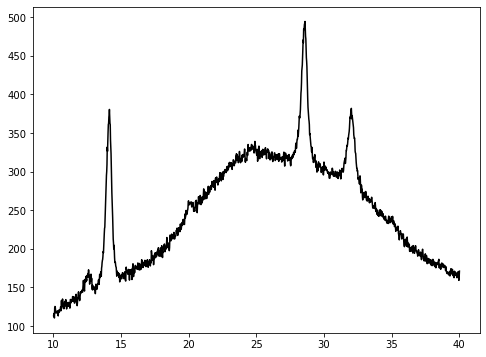

In [29]:
path = r'XRD_data/chem1'
all_files = sorted(glob.glob(path+"/*.plt"))
print(all_files)
#   Quick Plot of Full XRD Data

fig0, ax0 = plt.subplots(figsize=(8,6))

#   No background or filtering
chem = pd.read_csv(all_files[-1], delim_whitespace=True, skiprows = 16)
chem.columns = ["2Theta","Intensity"]
ax0.plot(chem["2Theta"],chem["Intensity"],'k-')

['XRD_data/chem1/chem1_centerslice.plt', 'XRD_data/chem1/chem1_edgeslice.plt', 'XRD_data/chem1/chem1_full.plt']
Maximum number of iterations exceeded
Maximum number of iterations exceeded


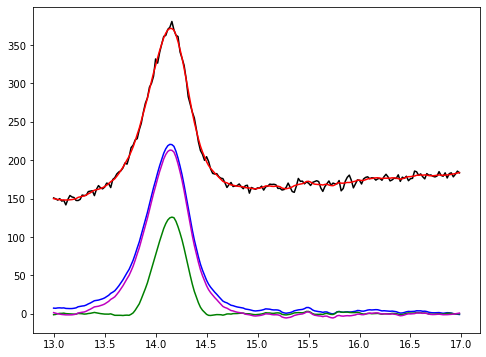

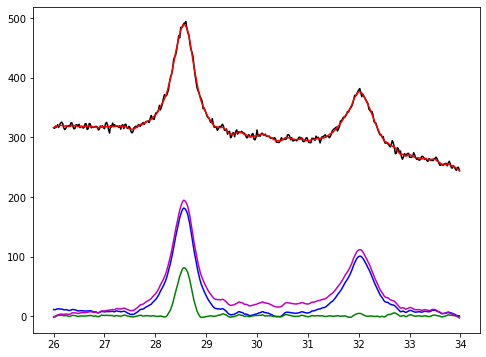

In [41]:
path = r'XRD_data/chem1'
all_files = sorted(glob.glob(path+"/*.plt"))
print(all_files)
#   Look at the effect of background subtraction using [100] peak on full integration

limit1 = 13
limit2 = 17
fig1, ax1 = plt.subplots(figsize=(8,6))

#   No background or filtering
chem = pd.read_csv(all_files[-1], delim_whitespace=True, skiprows = 16)
chem.columns = ["2Theta","Intensity"]
chem_np = np.array(chem)
theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1,limit2)
chem_cut = np.column_stack((theta_cut,chem_cut))
chem_out = pd.DataFrame(chem_cut)
chem_out.columns = ["2Theta","Intensity"]
ax1.plot(chem_out["2Theta"],chem_out["Intensity"],'k-')

#   No background but filtering
chem_cut_filter = savgol_filter(chem_cut[:,1],savgol_average,2)
chem_cut_filter = np.column_stack((theta_cut,chem_cut_filter))
chem_out_filter = pd.DataFrame(chem_cut_filter)
chem_out_filter.columns = ["2Theta","Intensity"]
ax1.plot(chem_out_filter["2Theta"],chem_out_filter["Intensity"],'r-')


#   ALS background and filtering
chem_als = xrd_focus_als(all_files[-1],limit1,limit2)
ax1.plot(chem_als["2Theta"],chem_als["Intensity"],'b-')

#   arPLS background and filtering
chem_arPLS = xrd_focus_arPLS(all_files[-1],limit1,limit2)
ax1.plot(chem_arPLS["2Theta"],chem_arPLS["Intensity"],'g-')

#   Linear background and filtering
chem = pd.read_csv(all_files[-1], delim_whitespace=True, skiprows = 16)
chem.columns = ["2Theta","Intensity"]
chem_np = np.array(chem)
theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1,limit2)
chem_cut = back_subtract(theta_cut,chem_cut,6)
chem_cut = savgol_filter(chem_cut,savgol_average,2)
chem_cut = np.column_stack((theta_cut,chem_cut))
chem_back = pd.DataFrame(chem_cut)
chem_back.columns = ["2Theta","Intensity"]
ax1.plot(chem_back["2Theta"],chem_back["Intensity"],'m-')

#   Look at the effect of background subtraction using [200] peak on full integration

limit1 = 26
limit2 = 34
fig2, ax2 = plt.subplots(figsize=(8,6))

#   No background or filtering
chem = pd.read_csv(all_files[-1], delim_whitespace=True, skiprows = 16)
chem.columns = ["2Theta","Intensity"]
chem_np = np.array(chem)
theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1,limit2)
chem_cut = np.column_stack((theta_cut,chem_cut))
chem_out = pd.DataFrame(chem_cut)
chem_out.columns = ["2Theta","Intensity"]
ax2.plot(chem_out["2Theta"],chem_out["Intensity"],'k-')

#   No background but filtering
chem_cut_filter = savgol_filter(chem_cut[:,1],savgol_average,2)
chem_cut_filter = np.column_stack((theta_cut,chem_cut_filter))
chem_out_filter = pd.DataFrame(chem_cut_filter)
chem_out_filter.columns = ["2Theta","Intensity"]
ax2.plot(chem_out_filter["2Theta"],chem_out_filter["Intensity"],'r-')


#   ALS background and filtering
chem_als = xrd_focus_als(all_files[-1],limit1,limit2)
ax2.plot(chem_als["2Theta"],chem_als["Intensity"],'b-')

#   arPLS background and filtering
chem_arPLS = xrd_focus_arPLS(all_files[-1],limit1,limit2)
ax2.plot(chem_arPLS["2Theta"],chem_arPLS["Intensity"],'g-')

#   Linear background and filtering
chem = pd.read_csv(all_files[-1], delim_whitespace=True, skiprows = 16)
chem.columns = ["2Theta","Intensity"]
chem_np = np.array(chem)
theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1,limit2)
chem_cut = back_subtract(theta_cut,chem_cut,6)
chem_cut = savgol_filter(chem_cut,savgol_average,2)
chem_cut = np.column_stack((theta_cut,chem_cut))
chem_back = pd.DataFrame(chem_cut)
chem_back.columns = ["2Theta","Intensity"]
ax2.plot(chem_back["2Theta"],chem_back["Intensity"],'m-')

## Observations
*   Filtering may not be advantageous
*   Basic background subtraction seems to the smallest amount with regards to peak distortion

centerslice 6.261795624725189
edgeslice 6.290023499889534
full 6.2669658819893606
centerslice 6.246115743529522
edgeslice 6.264237970844639
full 6.247197166277426
centerslice 6.2444368287736225
edgeslice 6.257417026093911
full 6.243899877290778


Text(0.5, 1.0, '[210] Peak')

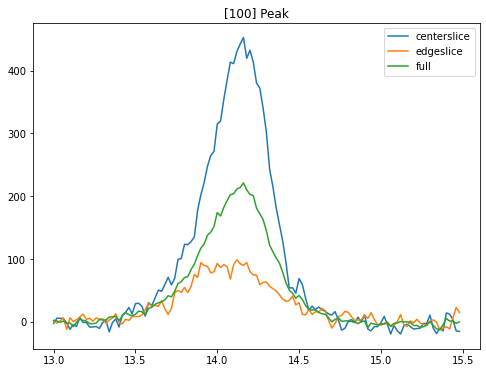

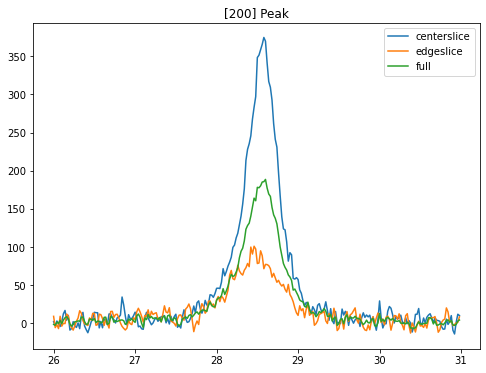

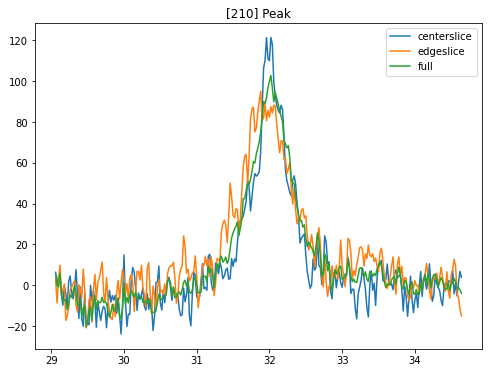

In [70]:
#   Effect or Peak/Integration on Lattice Determination
path = r'XRD_data/chem1'
all_files = sorted(glob.glob(path+"/*.plt"))
#   [100] center, full, edge: how many peaks and locations (e.g. determination of lattice)
limit1_100 = 13
limit2_100 = 15.5

#   Looking at simple background subtracted data
fig3, ax3 = plt.subplots(figsize=(8,6))
for each in all_files:
    chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
    chem.columns = ["2Theta","Intensity"]
    chem_np = np.array(chem)
    theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1_100,limit2_100)
    chem_cut = back_subtract(theta_cut,chem_cut,6)
    chem_cut = np.column_stack((theta_cut,chem_cut))
    chem_out = pd.DataFrame(chem_cut)
    chem_out.columns = ["2Theta","Intensity"]
    ax3.plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    
    popt, pcov, chem_fit = xrd_fit(chem_out, limit1_100, limit2_100)
    lattice = cubic_lattice(popt[2],[1,0,0])
    print(each.split("_")[-1].split(".")[0], lattice)

ax3.legend()
ax3.set_title("[100] Peak")


#   [200] center, full, edge: how many peaks and locations (e.g. determination of lattice)
limit1_200 = limit1_100*2
limit2_200 = limit2_100*2

#   Looking at simple background subtracted data
fig4, ax4 = plt.subplots(figsize=(8,6))
for each in all_files:
    chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
    chem.columns = ["2Theta","Intensity"]
    chem_np = np.array(chem)
    theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1_200,limit2_200)
    chem_cut = back_subtract(theta_cut,chem_cut,6)
    chem_cut = np.column_stack((theta_cut,chem_cut))
    chem_out = pd.DataFrame(chem_cut)
    chem_out.columns = ["2Theta","Intensity"]
    ax4.plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    
    popt, pcov, chem_fit = xrd_fit(chem_out, limit1_200, limit2_200)
    lattice = cubic_lattice(popt[2],[2,0,0])
    print(each.split("_")[-1].split(".")[0], lattice)

ax4.legend()
ax4.set_title("[200] Peak")

#   [210] center, full, edge: how many peaks and locations (e.g. determination of lattice)
miller = [2,1,0]
limit1 = limit1_100*np.sqrt(miller[0]**2+miller[1]**2+miller[2]**2)
limit2 = limit2_100*np.sqrt(miller[0]**2+miller[1]**2+miller[2]**2)

#   Looking at simple background subtracted data
fig5, ax5 = plt.subplots(figsize=(8,6))
for each in all_files:
    chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
    chem.columns = ["2Theta","Intensity"]
    chem_np = np.array(chem)
    theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1,limit2)
    chem_cut = back_subtract(theta_cut,chem_cut,6)
    chem_cut = np.column_stack((theta_cut,chem_cut))
    chem_out = pd.DataFrame(chem_cut)
    chem_out.columns = ["2Theta","Intensity"]
    ax5.plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    
    popt, pcov, chem_fit = xrd_fit(chem_out, limit1, limit2)
    lattice = cubic_lattice(popt[2],[2,1,0])
    print(each.split("_")[-1].split(".")[0], lattice)

ax5.legend()
ax5.set_title("[210] Peak") 

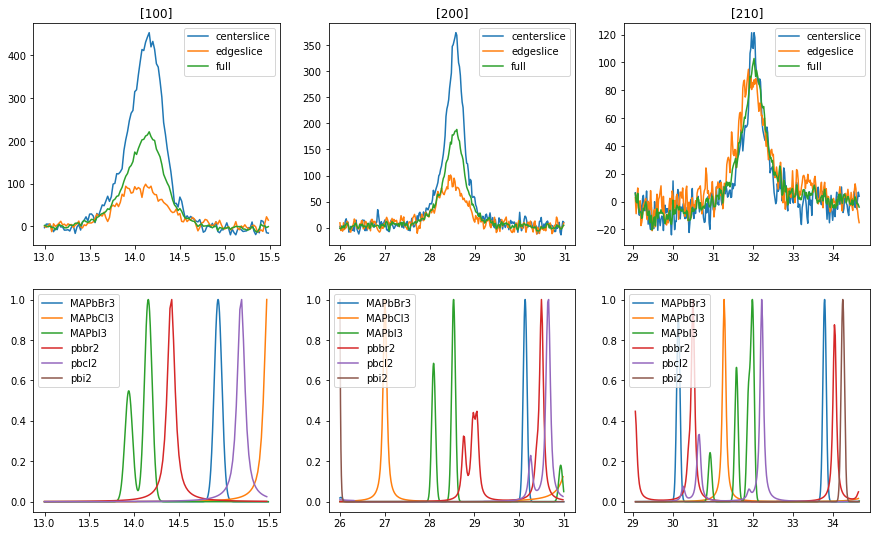

In [71]:
# Consideration of competing products (PbI2, PbBr2, PbCl2)

path = r'XRD_data/standards'
all_files = sorted(glob.glob(path+"/*.txt"))

#   Potential peaks in [100] range
fig6, ax6 = plt.subplots(2,3, figsize=(15, 9))

limits = [[limit1_100,limit2_100],[limit1_200,limit2_200],[limit1,limit2]]
peaks = ["[100]", "[200]", "[210]"]

for i in range(0,len(limits)):
    path = r'XRD_data/chem1'
    all_files = sorted(glob.glob(path+"/*.plt"))
    for each in all_files:
        chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
        chem.columns = ["2Theta","Intensity"]
        chem_np = np.array(chem)
        theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limits[i][0],limits[i][1])
        chem_cut = back_subtract(theta_cut,chem_cut,6)
        chem_cut = np.column_stack((theta_cut,chem_cut))
        chem_out = pd.DataFrame(chem_cut)
        chem_out.columns = ["2Theta","Intensity"]
        ax6[0,i].plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    ax6[0,i].legend()
    ax6[0,i].set_title(peaks[i])
    
    path = r'XRD_data/standards'
    all_files = sorted(glob.glob(path+"/*.txt"))
    for each in all_files:
        chem = pd.read_csv(each,delimiter='\t')
        chem.columns = ["2Theta","Intensity"]
        chem_np = np.array(chem)
        theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limits[i][0],limits[i][1])
        chem_cut = np.column_stack((theta_cut,chem_cut))
        chem_out = pd.DataFrame(chem_cut)
        chem_out.columns = ["2Theta","Intensity"]
        ax6[1,i].plot(chem_out["2Theta"],chem_out["Intensity"]/np.max(chem_out["Intensity"]),label = each.split("/")[-1].split(".")[0])
    ax6[1,i].legend()

In [ ]:
# Look at other sources of data (Amy's replicates) 

#   Chemistry 2

['XRD_data/chem2/chem2_centerslice.plt', 'XRD_data/chem2/chem2_edgeslice.plt', 'XRD_data/chem2/chem2_full.plt']


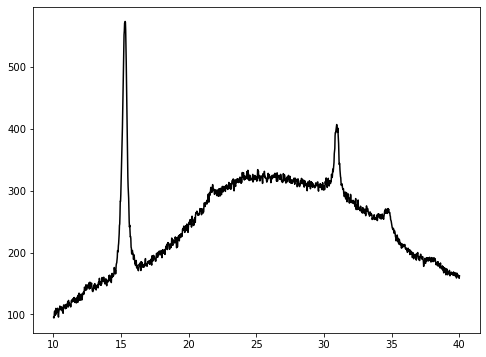

In [72]:
path = r'XRD_data/chem2'
all_files = sorted(glob.glob(path+"/*.plt"))
print(all_files)
#   Quick Plot of Full XRD Data

fig0, ax0 = plt.subplots(figsize=(8,6))

#   No background or filtering
chem = pd.read_csv(all_files[-1], delim_whitespace=True, skiprows = 16)
chem.columns = ["2Theta","Intensity"]
ax0.plot(chem["2Theta"],chem["Intensity"],'k-')

centerslice 5.788991686753487
edgeslice 5.781854160894015
full 5.790050049970706
centerslice 5.77581194349515
edgeslice 5.798571345358958
full 5.776371564659671
centerslice 6.335739053640333
edgeslice 5.8007391121798175
full 5.782119722761242


Text(0.5, 1.0, '[210] Peak')

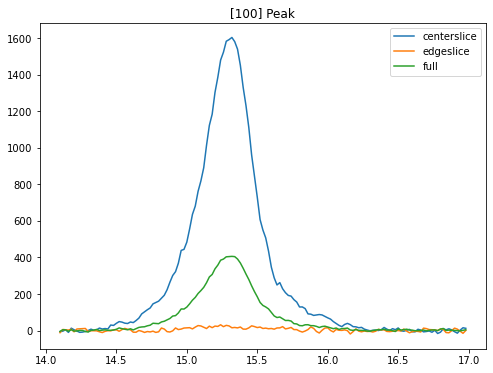

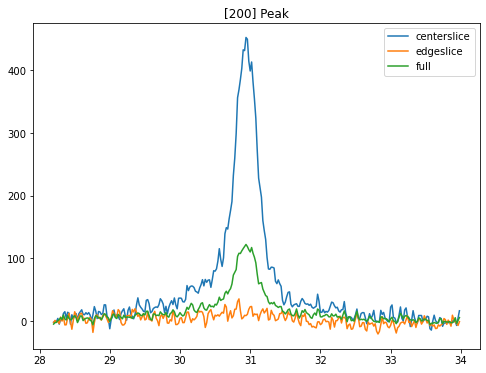

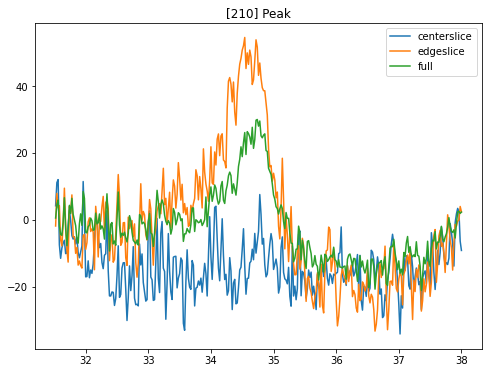

In [74]:
#   Effect or Peak/Integration on Lattice Determination
path = r'XRD_data/chem2'
all_files = sorted(glob.glob(path+"/*.plt"))
#   [100] center, full, edge: how many peaks and locations (e.g. determination of lattice)
limit1_100 = 14.1
limit2_100 = 17

#   Looking at simple background subtracted data
fig3, ax3 = plt.subplots(figsize=(8,6))
for each in all_files:
    chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
    chem.columns = ["2Theta","Intensity"]
    chem_np = np.array(chem)
    theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1_100,limit2_100)
    chem_cut = back_subtract(theta_cut,chem_cut,6)
    chem_cut = np.column_stack((theta_cut,chem_cut))
    chem_out = pd.DataFrame(chem_cut)
    chem_out.columns = ["2Theta","Intensity"]
    ax3.plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    
    popt, pcov, chem_fit = xrd_fit(chem_out, limit1_100, limit2_100)
    lattice = cubic_lattice(popt[2],[1,0,0])
    print(each.split("_")[-1].split(".")[0], lattice)

ax3.legend()
ax3.set_title("[100] Peak")


#   [200] center, full, edge: how many peaks and locations (e.g. determination of lattice)
limit1_200 = limit1_100*2
limit2_200 = limit2_100*2

#   Looking at simple background subtracted data
fig4, ax4 = plt.subplots(figsize=(8,6))
for each in all_files:
    chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
    chem.columns = ["2Theta","Intensity"]
    chem_np = np.array(chem)
    theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1_200,limit2_200)
    chem_cut = back_subtract(theta_cut,chem_cut,6)
    chem_cut = np.column_stack((theta_cut,chem_cut))
    chem_out = pd.DataFrame(chem_cut)
    chem_out.columns = ["2Theta","Intensity"]
    ax4.plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    
    popt, pcov, chem_fit = xrd_fit(chem_out, limit1_200, limit2_200)
    lattice = cubic_lattice(popt[2],[2,0,0])
    print(each.split("_")[-1].split(".")[0], lattice)

ax4.legend()
ax4.set_title("[200] Peak")

#   [210] center, full, edge: how many peaks and locations (e.g. determination of lattice)
miller = [2,1,0]
limit1 = limit1_100*np.sqrt(miller[0]**2+miller[1]**2+miller[2]**2)
limit2 = limit2_100*np.sqrt(miller[0]**2+miller[1]**2+miller[2]**2)

#   Looking at simple background subtracted data
fig5, ax5 = plt.subplots(figsize=(8,6))
for each in all_files:
    chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
    chem.columns = ["2Theta","Intensity"]
    chem_np = np.array(chem)
    theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1,limit2)
    chem_cut = back_subtract(theta_cut,chem_cut,6)
    chem_cut = np.column_stack((theta_cut,chem_cut))
    chem_out = pd.DataFrame(chem_cut)
    chem_out.columns = ["2Theta","Intensity"]
    ax5.plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    
    popt, pcov, chem_fit = xrd_fit(chem_out, limit1, limit2)
    lattice = cubic_lattice(popt[2],[2,1,0])
    print(each.split("_")[-1].split(".")[0], lattice)

ax5.legend()
ax5.set_title("[210] Peak") 

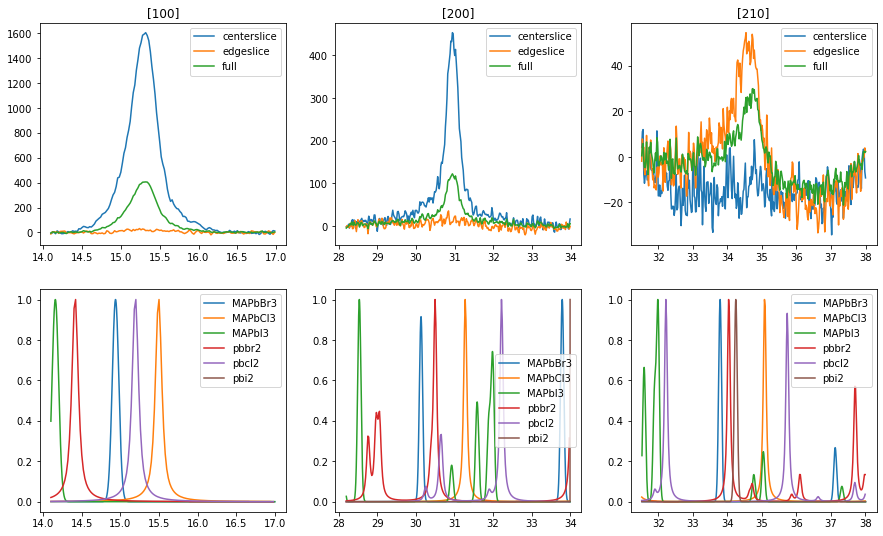

In [73]:
# Consideration of competing products (PbI2, PbBr2, PbCl2)
limit1_100 = 14.1
limit2_100 = 17
limit1_200 = limit1_100*2
limit2_200 = limit2_100*2
miller = [2,1,0]
limit1 = limit1_100*np.sqrt(miller[0]**2+miller[1]**2+miller[2]**2)
limit2 = limit2_100*np.sqrt(miller[0]**2+miller[1]**2+miller[2]**2)

#   Potential peaks in [100] range
fig6, ax6 = plt.subplots(2,3, figsize=(15, 9))

limits = [[limit1_100,limit2_100],[limit1_200,limit2_200],[limit1,limit2]]
peaks = ["[100]", "[200]", "[210]"]

for i in range(0,len(limits)):
    path = r'XRD_data/chem2'
    all_files = sorted(glob.glob(path+"/*.plt"))
    for each in all_files:
        chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
        chem.columns = ["2Theta","Intensity"]
        chem_np = np.array(chem)
        theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limits[i][0],limits[i][1])
        chem_cut = back_subtract(theta_cut,chem_cut,6)
        chem_cut = np.column_stack((theta_cut,chem_cut))
        chem_out = pd.DataFrame(chem_cut)
        chem_out.columns = ["2Theta","Intensity"]
        ax6[0,i].plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    ax6[0,i].legend()
    ax6[0,i].set_title(peaks[i])
    
    path = r'XRD_data/standards'
    all_files = sorted(glob.glob(path+"/*.txt"))
    for each in all_files:
        chem = pd.read_csv(each,delimiter='\t')
        chem.columns = ["2Theta","Intensity"]
        chem_np = np.array(chem)
        theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limits[i][0],limits[i][1])
        chem_cut = np.column_stack((theta_cut,chem_cut))
        chem_out = pd.DataFrame(chem_cut)
        chem_out.columns = ["2Theta","Intensity"]
        ax6[1,i].plot(chem_out["2Theta"],chem_out["Intensity"]/np.max(chem_out["Intensity"]),label = each.split("/")[-1].split(".")[0])
    ax6[1,i].legend()

#   Chemistry 3

['XRD_data/chem3/chem3_take2_centerslice.plt', 'XRD_data/chem3/chem3_take2_edgeslice.plt', 'XRD_data/chem3/chem3_take2_full.plt']


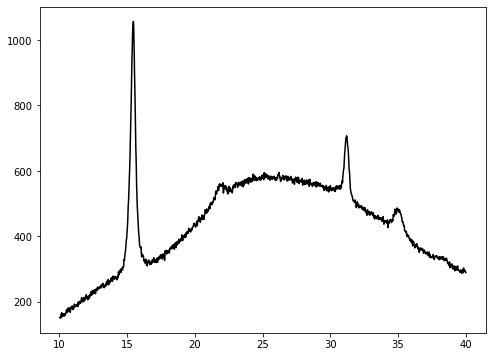

In [75]:
path = r'XRD_data/chem3'
all_files = sorted(glob.glob(path+"/*.plt"))
print(all_files)
#   Quick Plot of Full XRD Data

fig0, ax0 = plt.subplots(figsize=(8,6))

#   No background or filtering
chem = pd.read_csv(all_files[-1], delim_whitespace=True, skiprows = 16)
chem.columns = ["2Theta","Intensity"]
ax0.plot(chem["2Theta"],chem["Intensity"],'k-')

centerslice 5.737830321858368
edgeslice 5.78406579955707
full 5.737891264065046
centerslice 5.729929810459118
edgeslice 6.1505548918362996
full 5.730976970583481
centerslice 6.274854256962254
edgeslice 5.736233188405102
full 5.7266774822520965


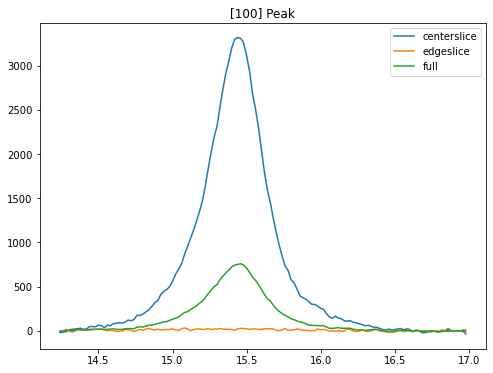

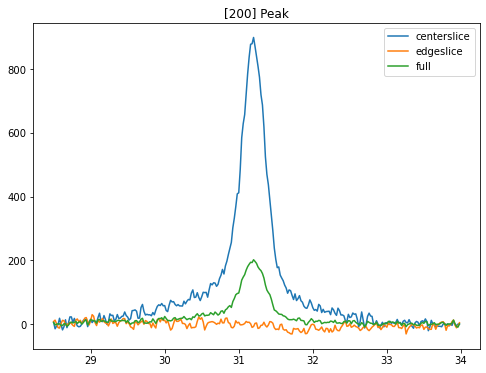

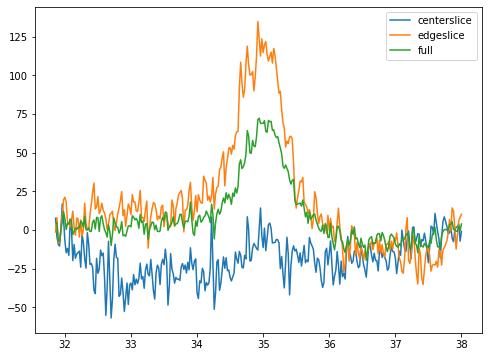

In [78]:
#   Effect or Peak/Integration on Lattice Determination
path = r'XRD_data/chem3'
all_files = sorted(glob.glob(path+"/*.plt"))
#   [100] center, full, edge: how many peaks and locations (e.g. determination of lattice)
limit1_100 = 14.25
limit2_100 = 17

#   Looking at simple background subtracted data
fig3, ax3 = plt.subplots(figsize=(8,6))
for each in all_files:
    chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
    chem.columns = ["2Theta","Intensity"]
    chem_np = np.array(chem)
    theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1_100,limit2_100)
    chem_cut = back_subtract(theta_cut,chem_cut,6)
    chem_cut = np.column_stack((theta_cut,chem_cut))
    chem_out = pd.DataFrame(chem_cut)
    chem_out.columns = ["2Theta","Intensity"]
    ax3.plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    
    popt, pcov, chem_fit = xrd_fit(chem_out, limit1_100, limit2_100)
    lattice = cubic_lattice(popt[2],[1,0,0])
    print(each.split("_")[-1].split(".")[0], lattice)

ax3.legend()
ax3.set_title("[100] Peak")


#   [200] center, full, edge: how many peaks and locations (e.g. determination of lattice)
limit1_200 = limit1_100*2
limit2_200 = limit2_100*2

#   Looking at simple background subtracted data
fig4, ax4 = plt.subplots(figsize=(8,6))
for each in all_files:
    chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
    chem.columns = ["2Theta","Intensity"]
    chem_np = np.array(chem)
    theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1_200,limit2_200)
    chem_cut = back_subtract(theta_cut,chem_cut,6)
    chem_cut = np.column_stack((theta_cut,chem_cut))
    chem_out = pd.DataFrame(chem_cut)
    chem_out.columns = ["2Theta","Intensity"]
    ax4.plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    
    popt, pcov, chem_fit = xrd_fit(chem_out, limit1_200, limit2_200)
    lattice = cubic_lattice(popt[2],[2,0,0])
    print(each.split("_")[-1].split(".")[0], lattice)

ax4.legend()
ax4.set_title("[200] Peak")

#   [210] center, full, edge: how many peaks and locations (e.g. determination of lattice)
miller = [2,1,0]
limit1 = limit1_100*np.sqrt(miller[0]**2+miller[1]**2+miller[2]**2)
limit2 = limit2_100*np.sqrt(miller[0]**2+miller[1]**2+miller[2]**2)

#   Looking at simple background subtracted data
fig5, ax5 = plt.subplots(figsize=(8,6))
for each in all_files:
    chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
    chem.columns = ["2Theta","Intensity"]
    chem_np = np.array(chem)
    theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1,limit2)
    chem_cut = back_subtract(theta_cut,chem_cut,6)
    chem_cut = np.column_stack((theta_cut,chem_cut))
    chem_out = pd.DataFrame(chem_cut)
    chem_out.columns = ["2Theta","Intensity"]
    ax5.plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    
    popt, pcov, chem_fit = xrd_fit(chem_out, limit1, limit2)
    lattice = cubic_lattice(popt[2],[2,1,0])
    print(each.split("_")[-1].split(".")[0], lattice)

ax5.legend()

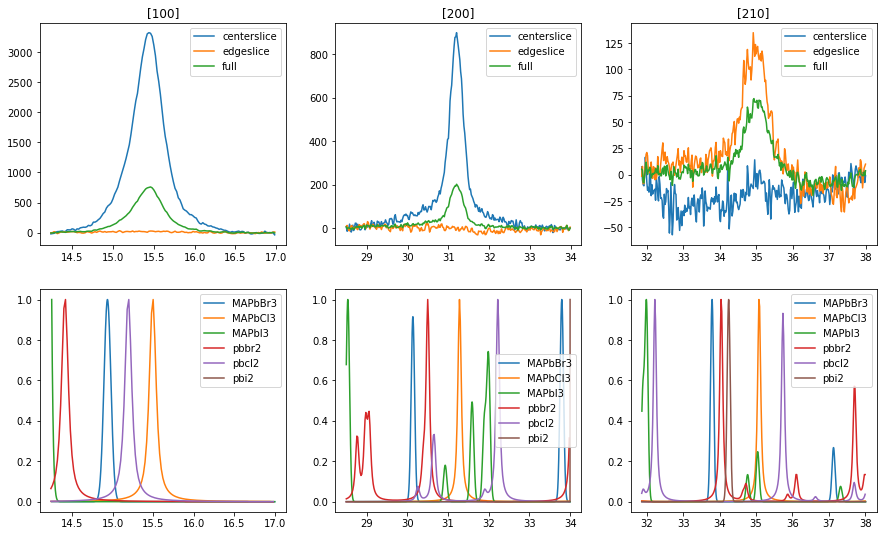

In [80]:
# Consideration of competing products (PbI2, PbBr2, PbCl2)

#   Potential peaks in [100] range
fig6, ax6 = plt.subplots(2,3, figsize=(15, 9))

limits = [[limit1_100,limit2_100],[limit1_200,limit2_200],[limit1,limit2]]
peaks = ["[100]", "[200]", "[210]"]

for i in range(0,len(limits)):
    path = r'XRD_data/chem3'
    all_files = sorted(glob.glob(path+"/*.plt"))
    for each in all_files:
        chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
        chem.columns = ["2Theta","Intensity"]
        chem_np = np.array(chem)
        theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limits[i][0],limits[i][1])
        chem_cut = back_subtract(theta_cut,chem_cut,6)
        chem_cut = np.column_stack((theta_cut,chem_cut))
        chem_out = pd.DataFrame(chem_cut)
        chem_out.columns = ["2Theta","Intensity"]
        ax6[0,i].plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    ax6[0,i].legend()
    ax6[0,i].set_title(peaks[i])
    
    path = r'XRD_data/standards'
    all_files = sorted(glob.glob(path+"/*.txt"))
    for each in all_files:
        chem = pd.read_csv(each,delimiter='\t')
        chem.columns = ["2Theta","Intensity"]
        chem_np = np.array(chem)
        theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limits[i][0],limits[i][1])
        chem_cut = np.column_stack((theta_cut,chem_cut))
        chem_out = pd.DataFrame(chem_cut)
        chem_out.columns = ["2Theta","Intensity"]
        ax6[1,i].plot(chem_out["2Theta"],chem_out["Intensity"]/np.max(chem_out["Intensity"]),label = each.split("/")[-1].split(".")[0])
    ax6[1,i].legend()

#   Chemistry 4

['XRD_data/chem4/chem4_edgeslice.plt', 'XRD_data/chem4/chem4_full.plt']


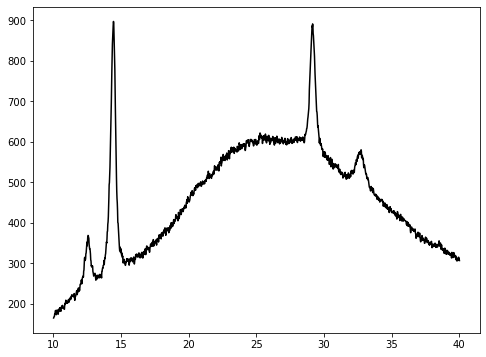

In [81]:
path = r'XRD_data/chem4'
all_files = sorted(glob.glob(path+"/*.plt"))
print(all_files)
#   Quick Plot of Full XRD Data

fig0, ax0 = plt.subplots(figsize=(8,6))

#   No background or filtering
chem = pd.read_csv(all_files[-1], delim_whitespace=True, skiprows = 16)
chem.columns = ["2Theta","Intensity"]
ax0.plot(chem["2Theta"],chem["Intensity"],'k-')

edgeslice 6.151874003478504
full 6.1308702892607565
edgeslice 6.140451899954913
full 6.11942205145212
edgeslice 6.122948160402073
full 6.115320539989145


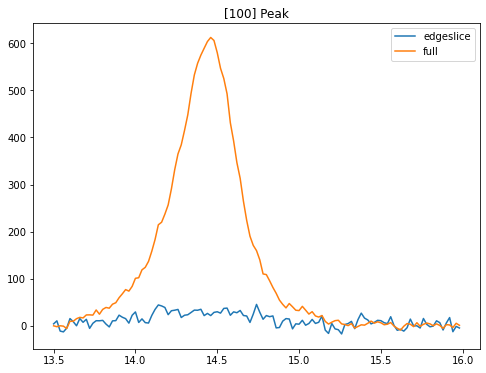

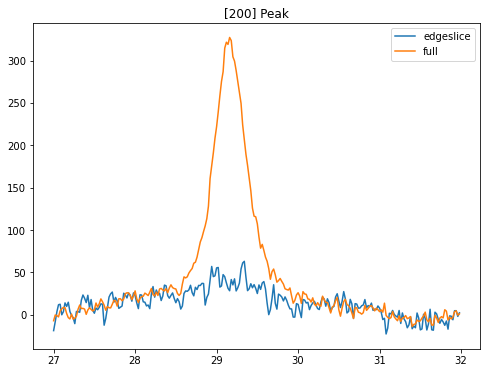

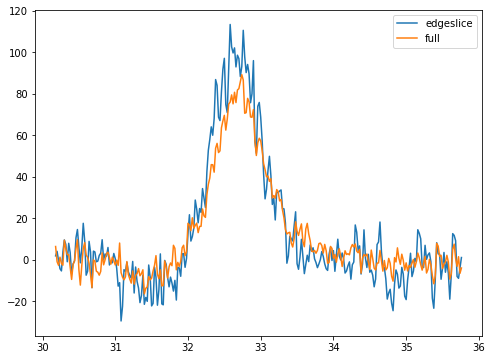

In [86]:
#   Effect or Peak/Integration on Lattice Determination
path = r'XRD_data/chem4'
all_files = sorted(glob.glob(path+"/*.plt"))
#   [100] center, full, edge: how many peaks and locations (e.g. determination of lattice)
limit1_100 = 13.5
limit2_100 = 16

#   Looking at simple background subtracted data
fig3, ax3 = plt.subplots(figsize=(8,6))
for each in all_files:
    chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
    chem.columns = ["2Theta","Intensity"]
    chem_np = np.array(chem)
    theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1_100,limit2_100)
    chem_cut = back_subtract(theta_cut,chem_cut,6)
    chem_cut = np.column_stack((theta_cut,chem_cut))
    chem_out = pd.DataFrame(chem_cut)
    chem_out.columns = ["2Theta","Intensity"]
    ax3.plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    
    popt, pcov, chem_fit = xrd_fit(chem_out, limit1_100, limit2_100)
    lattice = cubic_lattice(popt[2],[1,0,0])
    print(each.split("_")[-1].split(".")[0], lattice)

ax3.legend()
ax3.set_title("[100] Peak")


#   [200] center, full, edge: how many peaks and locations (e.g. determination of lattice)
limit1_200 = limit1_100*2
limit2_200 = limit2_100*2

#   Looking at simple background subtracted data
fig4, ax4 = plt.subplots(figsize=(8,6))
for each in all_files:
    chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
    chem.columns = ["2Theta","Intensity"]
    chem_np = np.array(chem)
    theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1_200,limit2_200)
    chem_cut = back_subtract(theta_cut,chem_cut,6)
    chem_cut = np.column_stack((theta_cut,chem_cut))
    chem_out = pd.DataFrame(chem_cut)
    chem_out.columns = ["2Theta","Intensity"]
    ax4.plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    
    popt, pcov, chem_fit = xrd_fit(chem_out, limit1_200, limit2_200)
    lattice = cubic_lattice(popt[2],[2,0,0])
    print(each.split("_")[-1].split(".")[0], lattice)

ax4.legend()
ax4.set_title("[200] Peak")

#   [210] center, full, edge: how many peaks and locations (e.g. determination of lattice)
miller = [2,1,0]
limit1 = limit1_100*np.sqrt(miller[0]**2+miller[1]**2+miller[2]**2)
limit2 = limit2_100*np.sqrt(miller[0]**2+miller[1]**2+miller[2]**2)

#   Looking at simple background subtracted data
fig5, ax5 = plt.subplots(figsize=(8,6))
for each in all_files:
    chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
    chem.columns = ["2Theta","Intensity"]
    chem_np = np.array(chem)
    theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1,limit2)
    chem_cut = back_subtract(theta_cut,chem_cut,6)
    chem_cut = np.column_stack((theta_cut,chem_cut))
    chem_out = pd.DataFrame(chem_cut)
    chem_out.columns = ["2Theta","Intensity"]
    ax5.plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    
    popt, pcov, chem_fit = xrd_fit(chem_out, limit1, limit2)
    lattice = cubic_lattice(popt[2],[2,1,0])
    print(each.split("_")[-1].split(".")[0], lattice)

ax5.legend()

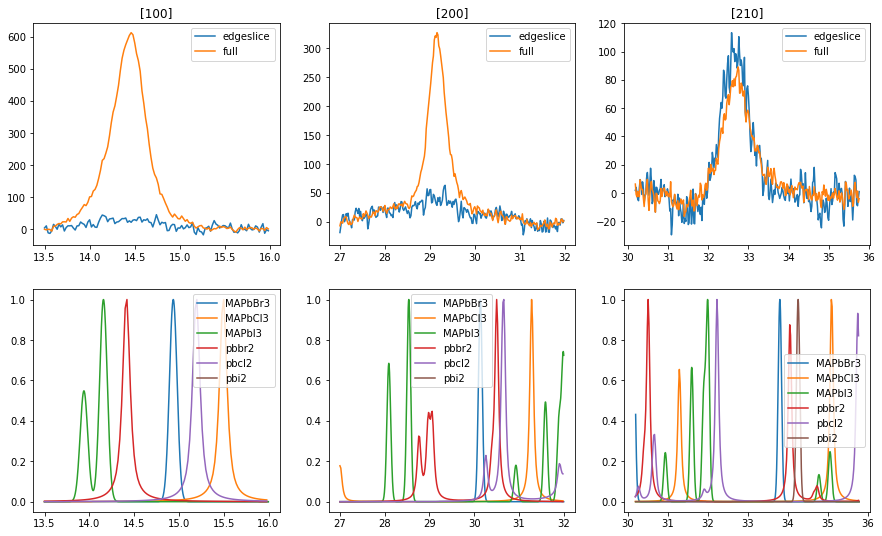

In [87]:
# Consideration of competing products (PbI2, PbBr2, PbCl2)

#   Potential peaks in [100] range
fig6, ax6 = plt.subplots(2,3, figsize=(15, 9))

limits = [[limit1_100,limit2_100],[limit1_200,limit2_200],[limit1,limit2]]
peaks = ["[100]", "[200]", "[210]"]

for i in range(0,len(limits)):
    path = r'XRD_data/chem4'
    all_files = sorted(glob.glob(path+"/*.plt"))
    for each in all_files:
        chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
        chem.columns = ["2Theta","Intensity"]
        chem_np = np.array(chem)
        theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limits[i][0],limits[i][1])
        chem_cut = back_subtract(theta_cut,chem_cut,6)
        chem_cut = np.column_stack((theta_cut,chem_cut))
        chem_out = pd.DataFrame(chem_cut)
        chem_out.columns = ["2Theta","Intensity"]
        ax6[0,i].plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    ax6[0,i].legend()
    ax6[0,i].set_title(peaks[i])
    
    path = r'XRD_data/standards'
    all_files = sorted(glob.glob(path+"/*.txt"))
    for each in all_files:
        chem = pd.read_csv(each,delimiter='\t')
        chem.columns = ["2Theta","Intensity"]
        chem_np = np.array(chem)
        theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limits[i][0],limits[i][1])
        chem_cut = np.column_stack((theta_cut,chem_cut))
        chem_out = pd.DataFrame(chem_cut)
        chem_out.columns = ["2Theta","Intensity"]
        ax6[1,i].plot(chem_out["2Theta"],chem_out["Intensity"]/np.max(chem_out["Intensity"]),label = each.split("/")[-1].split(".")[0])
    ax6[1,i].legend()

#   Chemistry 5

['XRD_data/chem5/chem5_center.plt', 'XRD_data/chem5/chem5_edge.plt', 'XRD_data/chem5/chem5_full.plt']


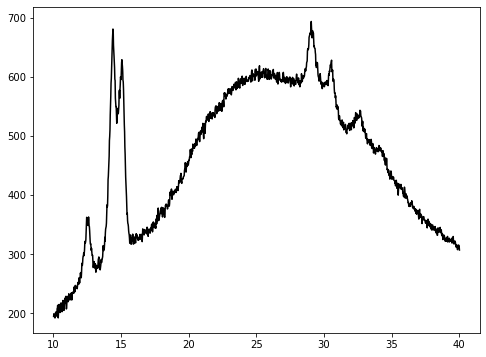

In [88]:
path = r'XRD_data/chem5'
all_files = sorted(glob.glob(path+"/*.plt"))
print(all_files)
#   Quick Plot of Full XRD Data

fig0, ax0 = plt.subplots(figsize=(8,6))

#   No background or filtering
chem = pd.read_csv(all_files[-1], delim_whitespace=True, skiprows = 16)
chem.columns = ["2Theta","Intensity"]
ax0.plot(chem["2Theta"],chem["Intensity"],'k-')

center 6.0211836111995005
edge 6.166017615046086
full 6.027505231639805
center 6.023390044905075
edge 6.148279834582537
full 6.11166541346181
center 6.155594522873727
edge 6.042355626854722
full 6.112920959137351


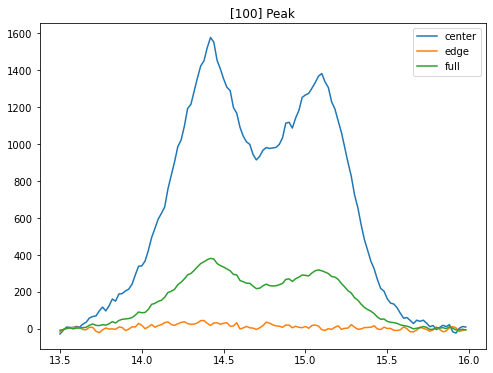

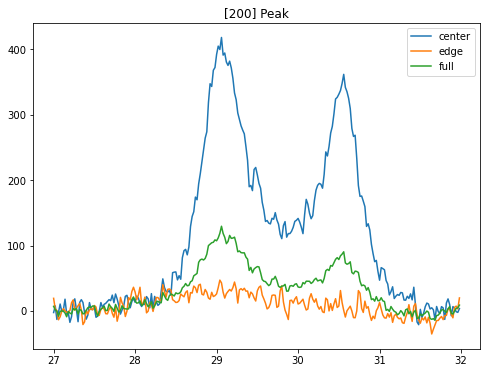

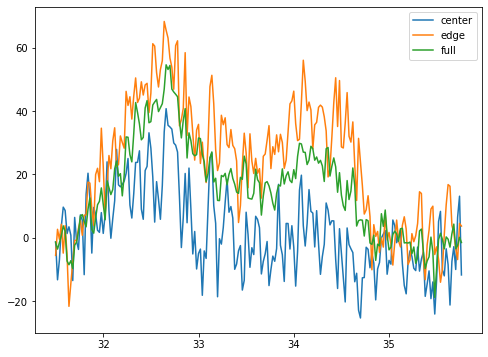

In [90]:
#   Effect or Peak/Integration on Lattice Determination
path = r'XRD_data/chem5'
all_files = sorted(glob.glob(path+"/*.plt"))
#   [100] center, full, edge: how many peaks and locations (e.g. determination of lattice)
limit1_100 = 13.5
limit2_100 = 16

#   Looking at simple background subtracted data
fig3, ax3 = plt.subplots(figsize=(8,6))
for each in all_files:
    chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
    chem.columns = ["2Theta","Intensity"]
    chem_np = np.array(chem)
    theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1_100,limit2_100)
    chem_cut = back_subtract(theta_cut,chem_cut,6)
    chem_cut = np.column_stack((theta_cut,chem_cut))
    chem_out = pd.DataFrame(chem_cut)
    chem_out.columns = ["2Theta","Intensity"]
    ax3.plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    
    popt, pcov, chem_fit = xrd_fit(chem_out, limit1_100, limit2_100)
    lattice = cubic_lattice(popt[2],[1,0,0])
    print(each.split("_")[-1].split(".")[0], lattice)

ax3.legend()
ax3.set_title("[100] Peak")


#   [200] center, full, edge: how many peaks and locations (e.g. determination of lattice)
limit1_200 = limit1_100*2
limit2_200 = limit2_100*2

#   Looking at simple background subtracted data
fig4, ax4 = plt.subplots(figsize=(8,6))
for each in all_files:
    chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
    chem.columns = ["2Theta","Intensity"]
    chem_np = np.array(chem)
    theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1_200,limit2_200)
    chem_cut = back_subtract(theta_cut,chem_cut,6)
    chem_cut = np.column_stack((theta_cut,chem_cut))
    chem_out = pd.DataFrame(chem_cut)
    chem_out.columns = ["2Theta","Intensity"]
    ax4.plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    
    popt, pcov, chem_fit = xrd_fit(chem_out, limit1_200, limit2_200)
    lattice = cubic_lattice(popt[2],[2,0,0])
    print(each.split("_")[-1].split(".")[0], lattice)

ax4.legend()
ax4.set_title("[200] Peak")

#   [210] center, full, edge: how many peaks and locations (e.g. determination of lattice)
miller = [2,1,0]
limit1 = 31.5
limit2 = limit2_100*np.sqrt(miller[0]**2+miller[1]**2+miller[2]**2)

#   Looking at simple background subtracted data
fig5, ax5 = plt.subplots(figsize=(8,6))
for each in all_files:
    chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
    chem.columns = ["2Theta","Intensity"]
    chem_np = np.array(chem)
    theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1,limit2)
    chem_cut = back_subtract(theta_cut,chem_cut,6)
    chem_cut = np.column_stack((theta_cut,chem_cut))
    chem_out = pd.DataFrame(chem_cut)
    chem_out.columns = ["2Theta","Intensity"]
    ax5.plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    
    popt, pcov, chem_fit = xrd_fit(chem_out, limit1, limit2)
    lattice = cubic_lattice(popt[2],[2,1,0])
    print(each.split("_")[-1].split(".")[0], lattice)

ax5.legend()

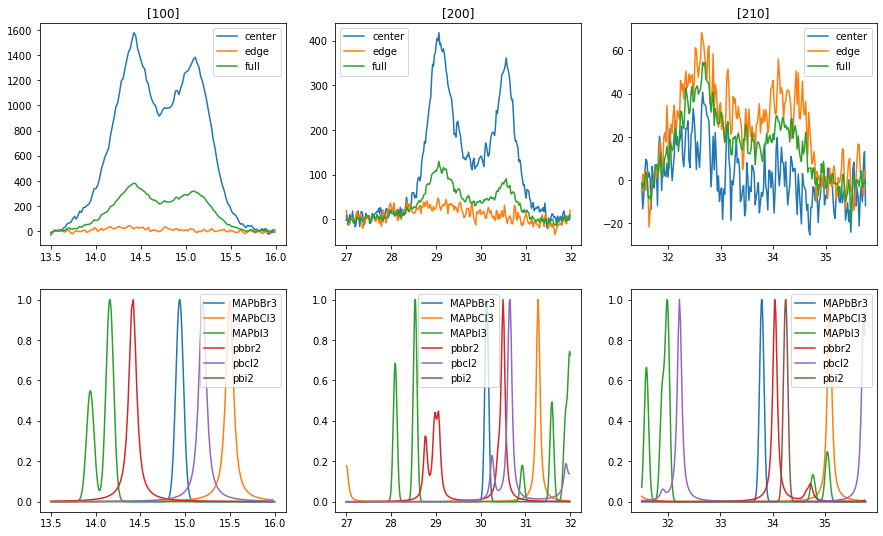

In [91]:
# Consideration of competing products (PbI2, PbBr2, PbCl2)

#   Potential peaks in [100] range
fig6, ax6 = plt.subplots(2,3, figsize=(15, 9))

limits = [[limit1_100,limit2_100],[limit1_200,limit2_200],[limit1,limit2]]
peaks = ["[100]", "[200]", "[210]"]

for i in range(0,len(limits)):
    path = r'XRD_data/chem5'
    all_files = sorted(glob.glob(path+"/*.plt"))
    for each in all_files:
        chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
        chem.columns = ["2Theta","Intensity"]
        chem_np = np.array(chem)
        theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limits[i][0],limits[i][1])
        chem_cut = back_subtract(theta_cut,chem_cut,6)
        chem_cut = np.column_stack((theta_cut,chem_cut))
        chem_out = pd.DataFrame(chem_cut)
        chem_out.columns = ["2Theta","Intensity"]
        ax6[0,i].plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    ax6[0,i].legend()
    ax6[0,i].set_title(peaks[i])
    
    path = r'XRD_data/standards'
    all_files = sorted(glob.glob(path+"/*.txt"))
    for each in all_files:
        chem = pd.read_csv(each,delimiter='\t')
        chem.columns = ["2Theta","Intensity"]
        chem_np = np.array(chem)
        theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limits[i][0],limits[i][1])
        chem_cut = np.column_stack((theta_cut,chem_cut))
        chem_out = pd.DataFrame(chem_cut)
        chem_out.columns = ["2Theta","Intensity"]
        ax6[1,i].plot(chem_out["2Theta"],chem_out["Intensity"]/np.max(chem_out["Intensity"]),label = each.split("/")[-1].split(".")[0])
    ax6[1,i].legend()

#   Chemistry 6

['XRD_data/chem6/chem6_center.plt', 'XRD_data/chem6/chem6_edgeslice.plt', 'XRD_data/chem6/chem6_full.plt']


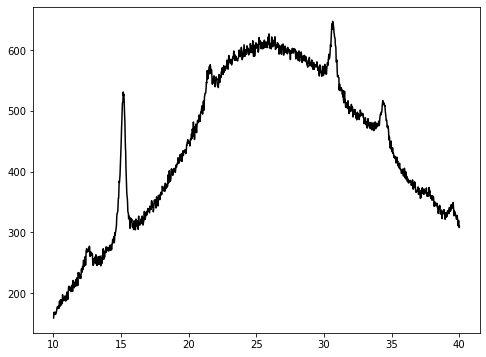

In [92]:
path = r'XRD_data/chem6'
all_files = sorted(glob.glob(path+"/*.plt"))
print(all_files)
#   Quick Plot of Full XRD Data

fig0, ax0 = plt.subplots(figsize=(8,6))

#   No background or filtering
chem = pd.read_csv(all_files[-1], delim_whitespace=True, skiprows = 16)
chem.columns = ["2Theta","Intensity"]
ax0.plot(chem["2Theta"],chem["Intensity"],'k-')

center 5.83651462615422
edgeslice 5.853853815821983
full 5.837582997548738
center 5.823906842510706
edgeslice 5.873622617479191
full 5.8262587394427685
center 5.8203988430282365
edgeslice 5.831767260238501
full 5.823348526204179


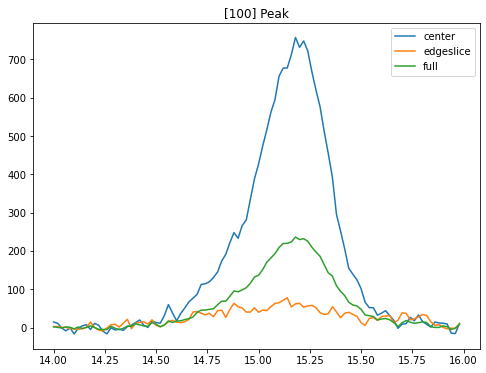

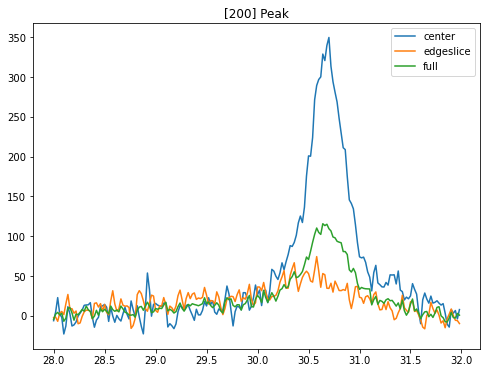

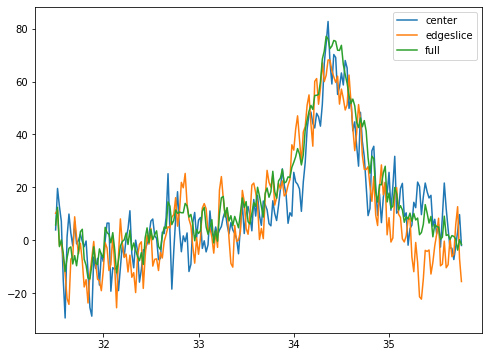

In [96]:
#   Effect or Peak/Integration on Lattice Determination
path = r'XRD_data/chem6'
all_files = sorted(glob.glob(path+"/*.plt"))
#   [100] center, full, edge: how many peaks and locations (e.g. determination of lattice)
limit1_100 = 14
limit2_100 = 16

#   Looking at simple background subtracted data
fig3, ax3 = plt.subplots(figsize=(8,6))
for each in all_files:
    chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
    chem.columns = ["2Theta","Intensity"]
    chem_np = np.array(chem)
    theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1_100,limit2_100)
    chem_cut = back_subtract(theta_cut,chem_cut,6)
    chem_cut = np.column_stack((theta_cut,chem_cut))
    chem_out = pd.DataFrame(chem_cut)
    chem_out.columns = ["2Theta","Intensity"]
    ax3.plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    
    popt, pcov, chem_fit = xrd_fit(chem_out, limit1_100, limit2_100)
    lattice = cubic_lattice(popt[2],[1,0,0])
    print(each.split("_")[-1].split(".")[0], lattice)

ax3.legend()
ax3.set_title("[100] Peak")


#   [200] center, full, edge: how many peaks and locations (e.g. determination of lattice)
limit1_200 = limit1_100*2
limit2_200 = limit2_100*2

#   Looking at simple background subtracted data
fig4, ax4 = plt.subplots(figsize=(8,6))
for each in all_files:
    chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
    chem.columns = ["2Theta","Intensity"]
    chem_np = np.array(chem)
    theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1_200,limit2_200)
    chem_cut = back_subtract(theta_cut,chem_cut,6)
    chem_cut = np.column_stack((theta_cut,chem_cut))
    chem_out = pd.DataFrame(chem_cut)
    chem_out.columns = ["2Theta","Intensity"]
    ax4.plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    
    popt, pcov, chem_fit = xrd_fit(chem_out, limit1_200, limit2_200)
    lattice = cubic_lattice(popt[2],[2,0,0])
    print(each.split("_")[-1].split(".")[0], lattice)

ax4.legend()
ax4.set_title("[200] Peak")

#   [210] center, full, edge: how many peaks and locations (e.g. determination of lattice)
miller = [2,1,0]
limit1 = 31.5
limit2 = limit2_100*np.sqrt(miller[0]**2+miller[1]**2+miller[2]**2)

#   Looking at simple background subtracted data
fig5, ax5 = plt.subplots(figsize=(8,6))
for each in all_files:
    chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
    chem.columns = ["2Theta","Intensity"]
    chem_np = np.array(chem)
    theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1,limit2)
    chem_cut = back_subtract(theta_cut,chem_cut,6)
    chem_cut = np.column_stack((theta_cut,chem_cut))
    chem_out = pd.DataFrame(chem_cut)
    chem_out.columns = ["2Theta","Intensity"]
    ax5.plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    
    popt, pcov, chem_fit = xrd_fit(chem_out, limit1, limit2)
    lattice = cubic_lattice(popt[2],[2,1,0])
    print(each.split("_")[-1].split(".")[0], lattice)

ax5.legend()

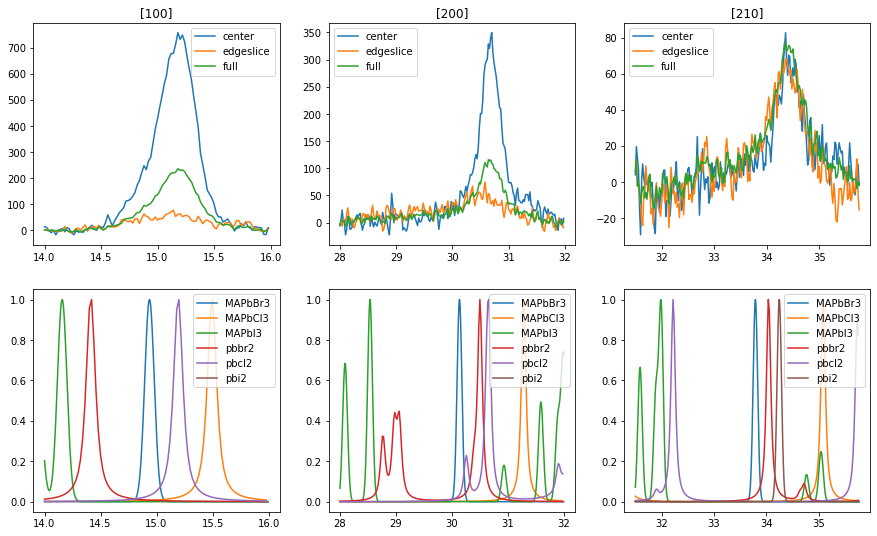

In [97]:
# Consideration of competing products (PbI2, PbBr2, PbCl2)

#   Potential peaks in [100] range
fig6, ax6 = plt.subplots(2,3, figsize=(15, 9))

limits = [[limit1_100,limit2_100],[limit1_200,limit2_200],[limit1,limit2]]
peaks = ["[100]", "[200]", "[210]"]

for i in range(0,len(limits)):
    path = r'XRD_data/chem6'
    all_files = sorted(glob.glob(path+"/*.plt"))
    for each in all_files:
        chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
        chem.columns = ["2Theta","Intensity"]
        chem_np = np.array(chem)
        theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limits[i][0],limits[i][1])
        chem_cut = back_subtract(theta_cut,chem_cut,6)
        chem_cut = np.column_stack((theta_cut,chem_cut))
        chem_out = pd.DataFrame(chem_cut)
        chem_out.columns = ["2Theta","Intensity"]
        ax6[0,i].plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    ax6[0,i].legend()
    ax6[0,i].set_title(peaks[i])
    
    path = r'XRD_data/standards'
    all_files = sorted(glob.glob(path+"/*.txt"))
    for each in all_files:
        chem = pd.read_csv(each,delimiter='\t')
        chem.columns = ["2Theta","Intensity"]
        chem_np = np.array(chem)
        theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limits[i][0],limits[i][1])
        chem_cut = np.column_stack((theta_cut,chem_cut))
        chem_out = pd.DataFrame(chem_cut)
        chem_out.columns = ["2Theta","Intensity"]
        ax6[1,i].plot(chem_out["2Theta"],chem_out["Intensity"]/np.max(chem_out["Intensity"]),label = each.split("/")[-1].split(".")[0])
    ax6[1,i].legend()

#   Chemsitry 7

['XRD_data/chem7/chem7_center.plt', 'XRD_data/chem7/chem7_edge.plt', 'XRD_data/chem7/chem7_full.plt']


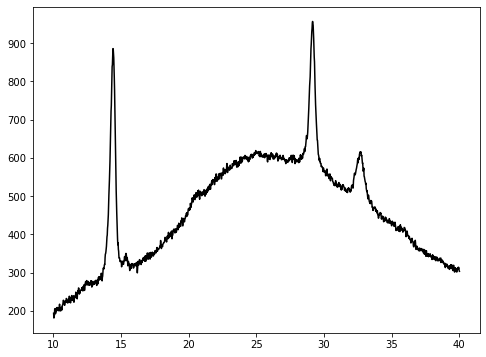

In [98]:
path = r'XRD_data/chem7'
all_files = sorted(glob.glob(path+"/*.plt"))
print(all_files)
#   Quick Plot of Full XRD Data

fig0, ax0 = plt.subplots(figsize=(8,6))

#   No background or filtering
chem = pd.read_csv(all_files[-1], delim_whitespace=True, skiprows = 16)
chem.columns = ["2Theta","Intensity"]
ax0.plot(chem["2Theta"],chem["Intensity"],'k-')

center 6.141883748748715
edge 6.166075398796463
full 6.142315650983715
center 6.1228883619369645
edge 6.1490959960280485
full 6.122764104388372
center 6.128304933016901
edge 6.1309685253985995
full 6.12310556117329


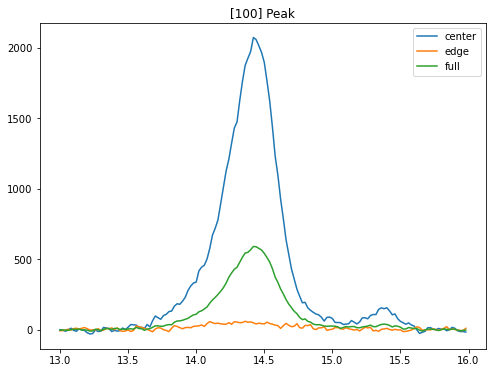

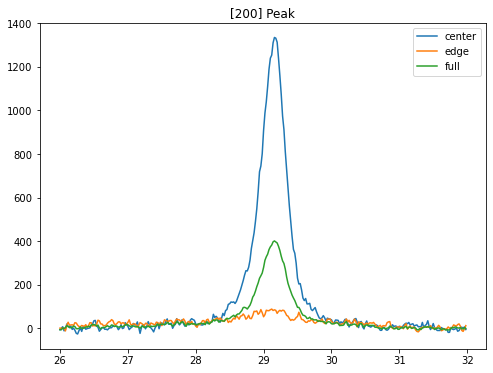

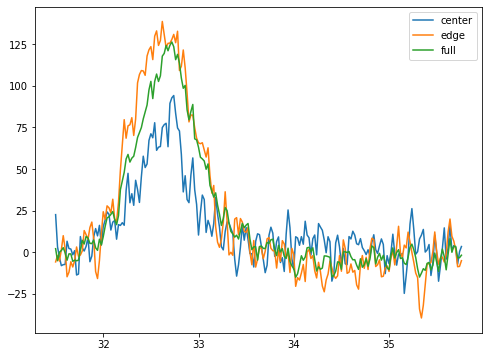

In [103]:
#   Effect or Peak/Integration on Lattice Determination
path = r'XRD_data/chem7'
all_files = sorted(glob.glob(path+"/*.plt"))
#   [100] center, full, edge: how many peaks and locations (e.g. determination of lattice)
limit1_100 = 13
limit2_100 = 16

#   Looking at simple background subtracted data
fig3, ax3 = plt.subplots(figsize=(8,6))
for each in all_files:
    chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
    chem.columns = ["2Theta","Intensity"]
    chem_np = np.array(chem)
    theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1_100,limit2_100)
    chem_cut = back_subtract(theta_cut,chem_cut,6)
    chem_cut = np.column_stack((theta_cut,chem_cut))
    chem_out = pd.DataFrame(chem_cut)
    chem_out.columns = ["2Theta","Intensity"]
    ax3.plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    
    popt, pcov, chem_fit = xrd_fit(chem_out, limit1_100, limit2_100)
    lattice = cubic_lattice(popt[2],[1,0,0])
    print(each.split("_")[-1].split(".")[0], lattice)

ax3.legend()
ax3.set_title("[100] Peak")


#   [200] center, full, edge: how many peaks and locations (e.g. determination of lattice)
limit1_200 = limit1_100*2
limit2_200 = limit2_100*2

#   Looking at simple background subtracted data
fig4, ax4 = plt.subplots(figsize=(8,6))
for each in all_files:
    chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
    chem.columns = ["2Theta","Intensity"]
    chem_np = np.array(chem)
    theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1_200,limit2_200)
    chem_cut = back_subtract(theta_cut,chem_cut,6)
    chem_cut = np.column_stack((theta_cut,chem_cut))
    chem_out = pd.DataFrame(chem_cut)
    chem_out.columns = ["2Theta","Intensity"]
    ax4.plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    
    popt, pcov, chem_fit = xrd_fit(chem_out, limit1_200, limit2_200)
    lattice = cubic_lattice(popt[2],[2,0,0])
    print(each.split("_")[-1].split(".")[0], lattice)

ax4.legend()
ax4.set_title("[200] Peak")

#   [210] center, full, edge: how many peaks and locations (e.g. determination of lattice)
miller = [2,1,0]
limit1 = 31.5
limit2 = limit2_100*np.sqrt(miller[0]**2+miller[1]**2+miller[2]**2)

#   Looking at simple background subtracted data
fig5, ax5 = plt.subplots(figsize=(8,6))
for each in all_files:
    chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
    chem.columns = ["2Theta","Intensity"]
    chem_np = np.array(chem)
    theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1,limit2)
    chem_cut = back_subtract(theta_cut,chem_cut,6)
    chem_cut = np.column_stack((theta_cut,chem_cut))
    chem_out = pd.DataFrame(chem_cut)
    chem_out.columns = ["2Theta","Intensity"]
    ax5.plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    
    popt, pcov, chem_fit = xrd_fit(chem_out, limit1, limit2)
    lattice = cubic_lattice(popt[2],[2,1,0])
    print(each.split("_")[-1].split(".")[0], lattice)

ax5.legend()

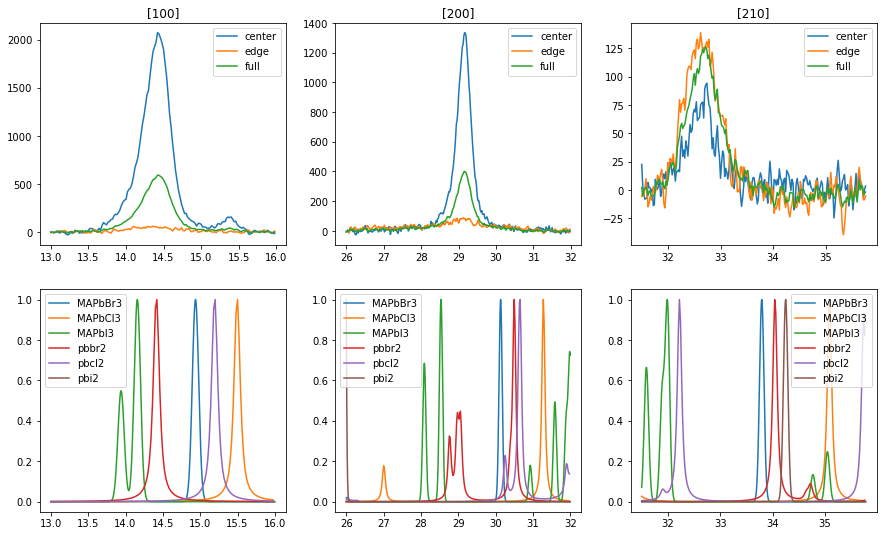

In [102]:
# Consideration of competing products (PbI2, PbBr2, PbCl2)

#   Potential peaks in [100] range
fig6, ax6 = plt.subplots(2,3, figsize=(15, 9))

limits = [[limit1_100,limit2_100],[limit1_200,limit2_200],[limit1,limit2]]
peaks = ["[100]", "[200]", "[210]"]

for i in range(0,len(limits)):
    path = r'XRD_data/chem7'
    all_files = sorted(glob.glob(path+"/*.plt"))
    for each in all_files:
        chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
        chem.columns = ["2Theta","Intensity"]
        chem_np = np.array(chem)
        theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limits[i][0],limits[i][1])
        chem_cut = back_subtract(theta_cut,chem_cut,6)
        chem_cut = np.column_stack((theta_cut,chem_cut))
        chem_out = pd.DataFrame(chem_cut)
        chem_out.columns = ["2Theta","Intensity"]
        ax6[0,i].plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    ax6[0,i].legend()
    ax6[0,i].set_title(peaks[i])
    
    path = r'XRD_data/standards'
    all_files = sorted(glob.glob(path+"/*.txt"))
    for each in all_files:
        chem = pd.read_csv(each,delimiter='\t')
        chem.columns = ["2Theta","Intensity"]
        chem_np = np.array(chem)
        theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limits[i][0],limits[i][1])
        chem_cut = np.column_stack((theta_cut,chem_cut))
        chem_out = pd.DataFrame(chem_cut)
        chem_out.columns = ["2Theta","Intensity"]
        ax6[1,i].plot(chem_out["2Theta"],chem_out["Intensity"]/np.max(chem_out["Intensity"]),label = each.split("/")[-1].split(".")[0])
    ax6[1,i].legend()

##  Observations

Appears to be single phase but unexplained peak in one frame. Since it doesn't show up any where else the pattern attribute it to some contaminant. For context, chemistry 7 is MAPbI1.5Br1.5 - a compound I've made many many times and hve always seen it appear as single phase. 

### TODO Loop in Amy's data to replace center.

#   Chemistry 8

['XRD_data/chem8/chem8_center.plt', 'XRD_data/chem8/chem8_edge.plt', 'XRD_data/chem8/chem8_full.plt']


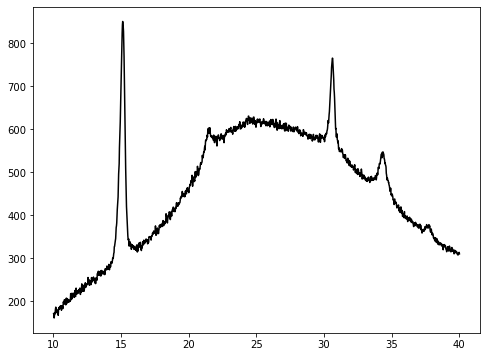

In [104]:
path = r'XRD_data/chem8'
all_files = sorted(glob.glob(path+"/*.plt"))
print(all_files)
#   Quick Plot of Full XRD Data

fig0, ax0 = plt.subplots(figsize=(8,6))

#   No background or filtering
chem = pd.read_csv(all_files[-1], delim_whitespace=True, skiprows = 16)
chem.columns = ["2Theta","Intensity"]
ax0.plot(chem["2Theta"],chem["Intensity"],'k-')

center 5.8531970320036555
edge 5.8891861942769275
full 5.853891331988518
center 5.833948936524494
edge 5.874983766776929
full 5.835300711571755
center 5.833318445330088
edge 5.841325903036754
full 5.832413675151959


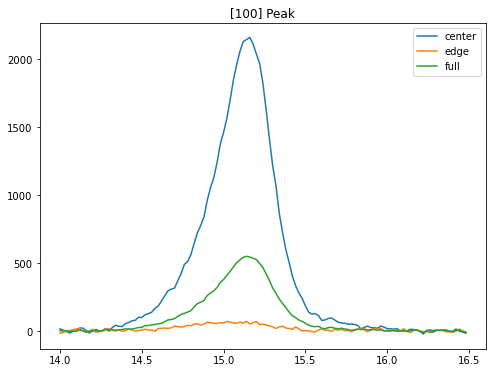

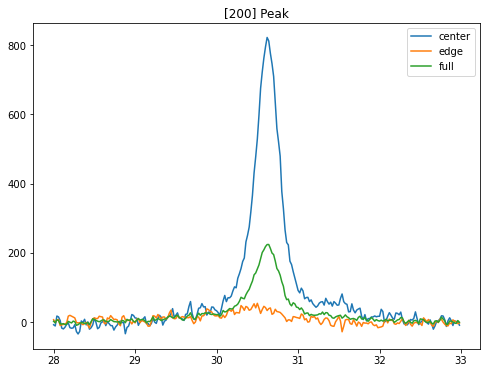

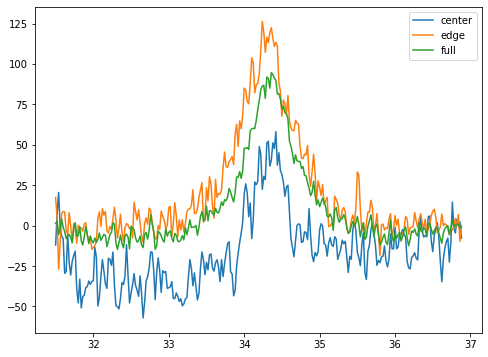

In [107]:
#   Effect or Peak/Integration on Lattice Determination
path = r'XRD_data/chem8'
all_files = sorted(glob.glob(path+"/*.plt"))
#   [100] center, full, edge: how many peaks and locations (e.g. determination of lattice)
limit1_100 = 14
limit2_100 = 16.5

#   Looking at simple background subtracted data
fig3, ax3 = plt.subplots(figsize=(8,6))
for each in all_files:
    chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
    chem.columns = ["2Theta","Intensity"]
    chem_np = np.array(chem)
    theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1_100,limit2_100)
    chem_cut = back_subtract(theta_cut,chem_cut,6)
    chem_cut = np.column_stack((theta_cut,chem_cut))
    chem_out = pd.DataFrame(chem_cut)
    chem_out.columns = ["2Theta","Intensity"]
    ax3.plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    
    popt, pcov, chem_fit = xrd_fit(chem_out, limit1_100, limit2_100)
    lattice = cubic_lattice(popt[2],[1,0,0])
    print(each.split("_")[-1].split(".")[0], lattice)

ax3.legend()
ax3.set_title("[100] Peak")


#   [200] center, full, edge: how many peaks and locations (e.g. determination of lattice)
limit1_200 = limit1_100*2
limit2_200 = limit2_100*2

#   Looking at simple background subtracted data
fig4, ax4 = plt.subplots(figsize=(8,6))
for each in all_files:
    chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
    chem.columns = ["2Theta","Intensity"]
    chem_np = np.array(chem)
    theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1_200,limit2_200)
    chem_cut = back_subtract(theta_cut,chem_cut,6)
    chem_cut = np.column_stack((theta_cut,chem_cut))
    chem_out = pd.DataFrame(chem_cut)
    chem_out.columns = ["2Theta","Intensity"]
    ax4.plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    
    popt, pcov, chem_fit = xrd_fit(chem_out, limit1_200, limit2_200)
    lattice = cubic_lattice(popt[2],[2,0,0])
    print(each.split("_")[-1].split(".")[0], lattice)

ax4.legend()
ax4.set_title("[200] Peak")

#   [210] center, full, edge: how many peaks and locations (e.g. determination of lattice)
miller = [2,1,0]
limit1 = 31.5
limit2 = limit2_100*np.sqrt(miller[0]**2+miller[1]**2+miller[2]**2)

#   Looking at simple background subtracted data
fig5, ax5 = plt.subplots(figsize=(8,6))
for each in all_files:
    chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
    chem.columns = ["2Theta","Intensity"]
    chem_np = np.array(chem)
    theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1,limit2)
    chem_cut = back_subtract(theta_cut,chem_cut,6)
    chem_cut = np.column_stack((theta_cut,chem_cut))
    chem_out = pd.DataFrame(chem_cut)
    chem_out.columns = ["2Theta","Intensity"]
    ax5.plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    
    popt, pcov, chem_fit = xrd_fit(chem_out, limit1, limit2)
    lattice = cubic_lattice(popt[2],[2,1,0])
    print(each.split("_")[-1].split(".")[0], lattice)

ax5.legend()

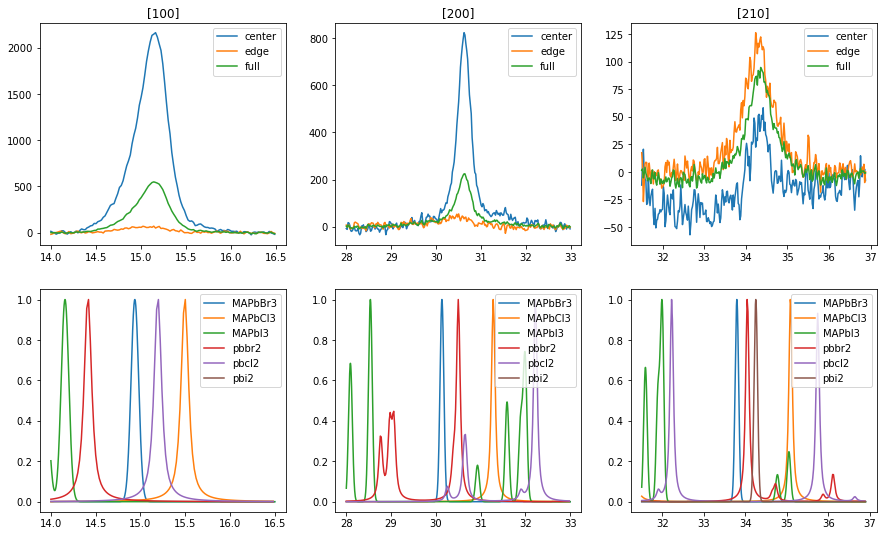

In [108]:
# Consideration of competing products (PbI2, PbBr2, PbCl2)

#   Potential peaks in [100] range
fig6, ax6 = plt.subplots(2,3, figsize=(15, 9))

limits = [[limit1_100,limit2_100],[limit1_200,limit2_200],[limit1,limit2]]
peaks = ["[100]", "[200]", "[210]"]

for i in range(0,len(limits)):
    path = r'XRD_data/chem8'
    all_files = sorted(glob.glob(path+"/*.plt"))
    for each in all_files:
        chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
        chem.columns = ["2Theta","Intensity"]
        chem_np = np.array(chem)
        theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limits[i][0],limits[i][1])
        chem_cut = back_subtract(theta_cut,chem_cut,6)
        chem_cut = np.column_stack((theta_cut,chem_cut))
        chem_out = pd.DataFrame(chem_cut)
        chem_out.columns = ["2Theta","Intensity"]
        ax6[0,i].plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    ax6[0,i].legend()
    ax6[0,i].set_title(peaks[i])
    
    path = r'XRD_data/standards'
    all_files = sorted(glob.glob(path+"/*.txt"))
    for each in all_files:
        chem = pd.read_csv(each,delimiter='\t')
        chem.columns = ["2Theta","Intensity"]
        chem_np = np.array(chem)
        theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limits[i][0],limits[i][1])
        chem_cut = np.column_stack((theta_cut,chem_cut))
        chem_out = pd.DataFrame(chem_cut)
        chem_out.columns = ["2Theta","Intensity"]
        ax6[1,i].plot(chem_out["2Theta"],chem_out["Intensity"]/np.max(chem_out["Intensity"]),label = each.split("/")[-1].split(".")[0])
    ax6[1,i].legend()

#   Chemsitry 9

['XRD_data/chem9/chem9_center.plt', 'XRD_data/chem9/chem9_edge.plt', 'XRD_data/chem9/chem9_full.plt']


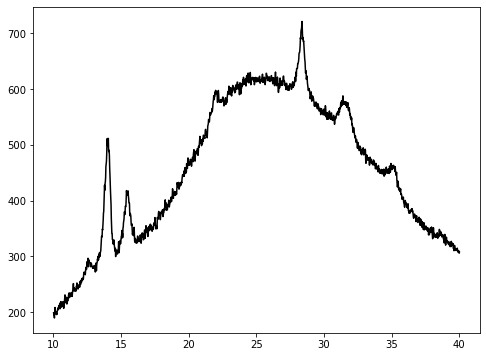

In [109]:
path = r'XRD_data/chem9'
all_files = sorted(glob.glob(path+"/*.plt"))
print(all_files)
#   Quick Plot of Full XRD Data

fig0, ax0 = plt.subplots(figsize=(8,6))

#   No background or filtering
chem = pd.read_csv(all_files[-1], delim_whitespace=True, skiprows = 16)
chem.columns = ["2Theta","Intensity"]
ax0.plot(chem["2Theta"],chem["Intensity"],'k-')

center 6.3137079277296415
edge 6.3354750670979225
full 6.312110746757217
center 6.288059646656529
edge 5.717950659651008
full 6.285423736865538
center 5.710459664859261
edge 5.7205745842757025
full 5.716027894696465


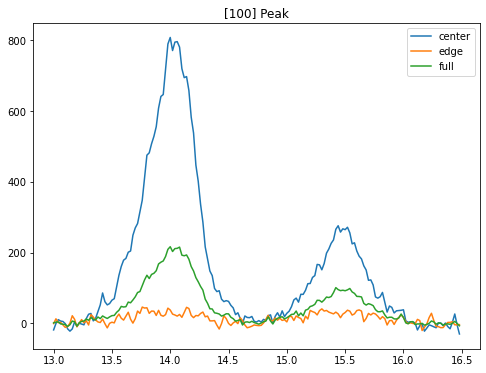

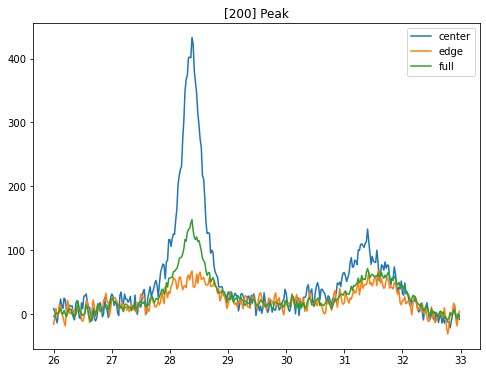

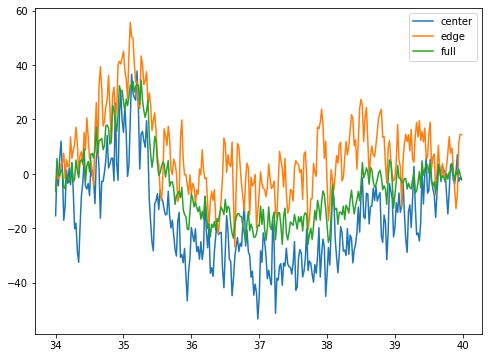

In [113]:
#   Effect or Peak/Integration on Lattice Determination
path = r'XRD_data/chem9'
all_files = sorted(glob.glob(path+"/*.plt"))
#   [100] center, full, edge: how many peaks and locations (e.g. determination of lattice)
limit1_100 = 13
limit2_100 = 16.5

#   Looking at simple background subtracted data
fig3, ax3 = plt.subplots(figsize=(8,6))
for each in all_files:
    chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
    chem.columns = ["2Theta","Intensity"]
    chem_np = np.array(chem)
    theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1_100,limit2_100)
    chem_cut = back_subtract(theta_cut,chem_cut,6)
    chem_cut = np.column_stack((theta_cut,chem_cut))
    chem_out = pd.DataFrame(chem_cut)
    chem_out.columns = ["2Theta","Intensity"]
    ax3.plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    
    popt, pcov, chem_fit = xrd_fit(chem_out, limit1_100, limit2_100)
    lattice = cubic_lattice(popt[2],[1,0,0])
    print(each.split("_")[-1].split(".")[0], lattice)

ax3.legend()
ax3.set_title("[100] Peak")


#   [200] center, full, edge: how many peaks and locations (e.g. determination of lattice)
limit1_200 = limit1_100*2
limit2_200 = limit2_100*2

#   Looking at simple background subtracted data
fig4, ax4 = plt.subplots(figsize=(8,6))
for each in all_files:
    chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
    chem.columns = ["2Theta","Intensity"]
    chem_np = np.array(chem)
    theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1_200,limit2_200)
    chem_cut = back_subtract(theta_cut,chem_cut,6)
    chem_cut = np.column_stack((theta_cut,chem_cut))
    chem_out = pd.DataFrame(chem_cut)
    chem_out.columns = ["2Theta","Intensity"]
    ax4.plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    
    popt, pcov, chem_fit = xrd_fit(chem_out, limit1_200, limit2_200)
    lattice = cubic_lattice(popt[2],[2,0,0])
    print(each.split("_")[-1].split(".")[0], lattice)

ax4.legend()
ax4.set_title("[200] Peak")

#   [210] center, full, edge: how many peaks and locations (e.g. determination of lattice)
miller = [2,1,0]
limit1 = 34
limit2 = 45

#   Looking at simple background subtracted data
fig5, ax5 = plt.subplots(figsize=(8,6))
for each in all_files:
    chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
    chem.columns = ["2Theta","Intensity"]
    chem_np = np.array(chem)
    theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limit1,limit2)
    chem_cut = back_subtract(theta_cut,chem_cut,6)
    chem_cut = np.column_stack((theta_cut,chem_cut))
    chem_out = pd.DataFrame(chem_cut)
    chem_out.columns = ["2Theta","Intensity"]
    ax5.plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    
    popt, pcov, chem_fit = xrd_fit(chem_out, limit1, limit2)
    lattice = cubic_lattice(popt[2],[2,1,0])
    print(each.split("_")[-1].split(".")[0], lattice)

ax5.legend()

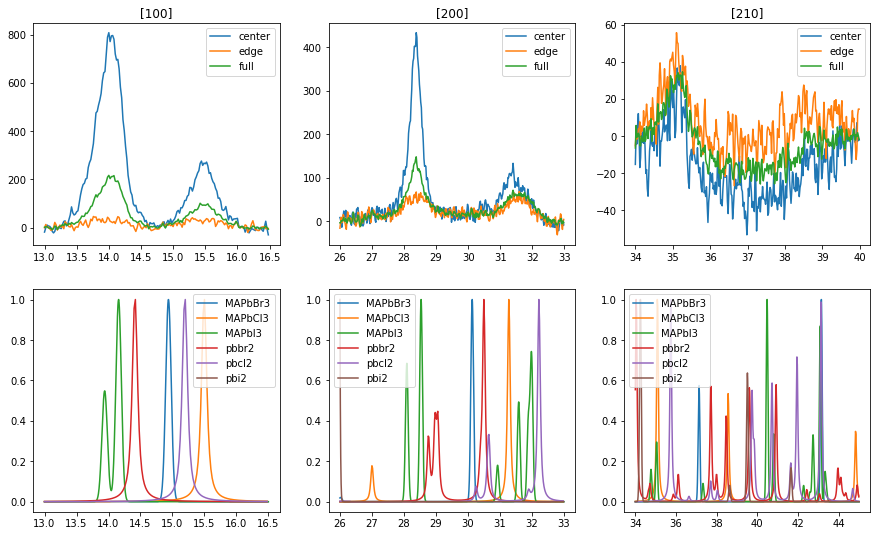

In [114]:
# Consideration of competing products (PbI2, PbBr2, PbCl2)

#   Potential peaks in [100] range
fig6, ax6 = plt.subplots(2,3, figsize=(15, 9))

limits = [[limit1_100,limit2_100],[limit1_200,limit2_200],[limit1,limit2]]
peaks = ["[100]", "[200]", "[210]"]

for i in range(0,len(limits)):
    path = r'XRD_data/chem9'
    all_files = sorted(glob.glob(path+"/*.plt"))
    for each in all_files:
        chem = pd.read_csv(each, delim_whitespace=True, skiprows = 16)
        chem.columns = ["2Theta","Intensity"]
        chem_np = np.array(chem)
        theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limits[i][0],limits[i][1])
        chem_cut = back_subtract(theta_cut,chem_cut,6)
        chem_cut = np.column_stack((theta_cut,chem_cut))
        chem_out = pd.DataFrame(chem_cut)
        chem_out.columns = ["2Theta","Intensity"]
        ax6[0,i].plot(chem_out["2Theta"],chem_out["Intensity"], label = each.split("_")[-1].split(".")[0])
    ax6[0,i].legend()
    ax6[0,i].set_title(peaks[i])
    
    path = r'XRD_data/standards'
    all_files = sorted(glob.glob(path+"/*.txt"))
    for each in all_files:
        chem = pd.read_csv(each,delimiter='\t')
        chem.columns = ["2Theta","Intensity"]
        chem_np = np.array(chem)
        theta_cut, chem_cut = trim_data(chem_np[:,0],chem_np[:,1],limits[i][0],limits[i][1])
        chem_cut = np.column_stack((theta_cut,chem_cut))
        chem_out = pd.DataFrame(chem_cut)
        chem_out.columns = ["2Theta","Intensity"]
        ax6[1,i].plot(chem_out["2Theta"],chem_out["Intensity"]/np.max(chem_out["Intensity"]),label = each.split("/")[-1].split(".")[0])
    ax6[1,i].legend()